The following example shows LSTM training on data that are labeled using the naive methods. The example shows evaluation using the mean (mu) threshold on 1 SD pair dataset only.

In [1]:
'''
Train Naive Methods (mu, mu+1sigma, mu+2sigma, mu+3sigma, EE, ORCE, IF, LOF, KMeans)
'''

import warnings
warnings.filterwarnings("ignore")


import os, math, random
import pandas as pd
import numpy as np
import random
import glob, sys
from sklearn.model_selection import train_test_split
from sklearn import *
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

sys.path.append('../')
from utils import get_full_path

In [2]:
db_dir = get_full_path('data_28')

snuba_split_set_dir = get_full_path('snuba', 'input_snuba')
threshold_dir = get_full_path('snuba', 'data')
output_dir = get_full_path('snuba', 'results')

from snuba.program_synthesis.heuristic_generator import HeuristicGenerator
from snuba.program_synthesis.synthesizer import Synthesizer
from snuba.program_synthesis.verifier import Verifier
from snuba.lstm.lstm import *

Using TensorFlow backend.


In [3]:
np.random.seed(42)

In [4]:
os.chdir(db_dir)
datasets = glob.glob('*.csv')
datasets_sorted = sorted(datasets)
print(datasets_sorted)

['dataset_00.csv', 'dataset_01.csv', 'dataset_02.csv', 'dataset_03.csv', 'dataset_04.csv', 'dataset_05.csv', 'dataset_06.csv', 'dataset_07.csv', 'dataset_08.csv', 'dataset_09.csv', 'dataset_10.csv', 'dataset_11.csv', 'dataset_12.csv', 'dataset_13.csv', 'dataset_14.csv', 'dataset_15.csv', 'dataset_16.csv', 'dataset_17.csv', 'dataset_18.csv', 'dataset_19.csv', 'dataset_20.csv', 'dataset_21.csv', 'dataset_22.csv', 'dataset_23.csv', 'dataset_24.csv', 'dataset_25.csv', 'dataset_26.csv', 'dataset_27.csv']


In [5]:
# Choose dataset_00
client1 = datasets_sorted[0]
client1

'dataset_00.csv'

In [6]:
def load_data(client):
    input_dir = snuba_split_set_dir+'/'+str(client[:-4])
    os.chdir(input_dir)
    train_original = pd.read_csv(glob.glob('train_original_*')[0])
    val_original = pd.read_csv(glob.glob('val_original_*')[0])
    test_original = pd.read_csv(glob.glob('test_original_*')[0])
    
    val_ground = np.load(glob.glob('val_ground_*')[0])
    test_ground = np.load(glob.glob('test_ground_*')[0])
    
    return train_original, val_original, test_original, val_ground, test_ground
    

In [7]:
train_original, val_original, test_original, val_ground, test_ground = load_data(client1)

In [8]:
# Take RTT data for train, val, and test set
train_data = train_original['rtt']
val_data = val_original['rtt']
test_data = test_original['rtt']

In [9]:
os.chdir(db_dir + '/')
clients = sorted(glob.glob('*.csv'))

# Specify client_number, in this case 0 since we are using dataset_00
client_number = 0
client1 = clients[client_number]

In [10]:
client1

'dataset_00.csv'

In [11]:
# Get the mu threshold value
naive_thresholds = []
os.chdir(db_dir + '/')

print('==============================================================')
print('    Client ' + client1[:-4]) 
print('==============================================================')
df = pd.read_csv(client1)

os.chdir(threshold_dir + '/')
df_threshold = pd.read_csv('Threshold-atl.csv')

# Specify which naive method. In this example: mean (mu)
# If desired naive method is ORCE, put:
# naive_threshold = df_threshold['ORCE'][client_number]
naive_threshold = df_threshold['Mean'][client_number]
print('Mean threshold: ', naive_threshold)

result_dir = output_dir+'/'+str(client1[:-4])

# Change to results dir
os.chdir(result_dir+'/')

    Client dataset_00
Mean threshold:  26.781


In [12]:
# Create naive labels for train set

def label_naive_data(x, naive_threshold):
    if x >= naive_threshold:
        y = -1
    else:
        y = 1
    return y

In [13]:
val_naive_label = val_ground
test_naive_label = test_ground

df_naive = train_original['rtt'].to_frame()
df_naive['label'] = df_naive['rtt'].apply(lambda x: label_naive_data(x, naive_threshold))

train_naive_label = df_naive['label']

In [14]:
# Validate

def validate(client1):
    
    bs = 32
    n = 20
    num_cells = 64
    lr = 0.001
    l2_reg = 0.3
    dropout_val = 0.2
    
    y_pred = lstm_simple(train_data, train_naive_label, val_data, val_naive_label, client=client1[:-4], heuristic='mean',\
                            bs=bs, n=n, num_cells=num_cells, lr=lr, l2_reg=l2_reg, dropout_val=dropout_val)

    predictions = np.round(y_pred)


    naive_val_acc = np.sum(predictions == val_naive_label)/float(np.shape(val_naive_label)[0])

    naive_val_f1 = metrics.f1_score(val_naive_label, predictions, average='micro', zero_division=0)
    naive_val_pr = metrics.precision_score(val_naive_label, predictions, average='micro', zero_division=0)
    naive_val_re = metrics.recall_score(val_naive_label, predictions, average='micro', zero_division=0)



    print ('=================================================================')
    print ('    Naive Mean Validation Results')
    print ('    Client ' + client1[:-4])
    print ('=================================================================')

    print ('Best Validation Accuracy: ', naive_val_acc)
    print ('Validation F1 Score: ', naive_val_f1)
    print ('Validation Best Pr: ', naive_val_pr)
    print ('Validation Best Re: ', naive_val_re)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 3334 samples, validate on 834 samples
Epoch 1/20
3334/3334 [==============================] - 2s 729us/step - loss: 17.7888 - accuracy: 0.7373 - val_loss: 15.7678 - val_accuracy: 0.8945
Epoch 2/20
3334/3334 [==============================] - 2s 563us/step - loss: 14.1569 - accuracy: 0.9055 - val_loss: 12.4550 - val_accuracy: 0.9532
Epoch 3/20
3334/3334 [==============================] - 2s 607us/step - loss: 11.1762 - accuracy: 0.9256 - val_loss: 9.7195 - val_accuracy: 0.9652
Epoch 4/20
3334/3334 [==============================] - 2s 591us/step - loss: 8.7276 - accuracy: 0.9178 - val_loss: 7.5020 - val_accuracy: 0.9652
Epoch 5/20
3334/3334 [==============================] - 2s 604us/step - loss: 6.7173 - accuracy: 0.9373 - val_loss: 5.7333 - val_accuracy: 0.9532
Epoch 6/20
3334/3334 [====================

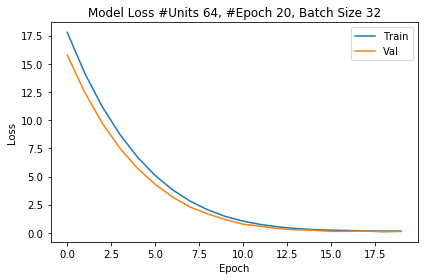

Accuracy: 95.32%
    Naive Mean Validation Results
    Client dataset_00
Best Validation Accuracy:  0.9532374100719424
Validation F1 Score:  0.9532374100719424
Validation Best Pr:  0.9532374100719424
Validation Best Re:  0.9532374100719424


In [15]:
validate(client1)

In [16]:
def test(client1):
    
    # Note: hyperparameters could be different for different datasets
    bs = 32
    n = 20
    num_cells = 64
    lr = 0.001
    l2_reg = 0.3
    dropout_val = 0.2
    early_stopping_epoch = n

    y_pred = lstm_simple(train_data, train_naive_label, test_data, test_naive_label, client=client1[:-4], heuristic='mean',\
                                bs=bs, n=early_stopping_epoch, \
                                num_cells=num_cells, lr=lr, l2_reg=l2_reg, dropout_val=dropout_val)

    predictions = np.round(y_pred)

    naive_test_acc = np.sum(predictions == test_naive_label)/float(np.shape(test_naive_label)[0])
    print ('=================================================================')
    print ('    Naive Mean Test Results')
    print ('    Client ' + client1[:-4])
    print ('=================================================================')
    print ('Test Accuracy: ', naive_test_acc)
    naive_test_f1 = metrics.f1_score(test_naive_label, predictions, average='micro', zero_division=0)
    print ('Test F1 Score: ', naive_test_f1)
    print ('Test Precision: ', metrics.precision_score(test_naive_label, predictions, average='micro', zero_division=0))
    print ('Test Recall: ', metrics.recall_score(test_naive_label, predictions, average='micro', zero_division=0))
    
    return naive_test_f1

Train on 3334 samples, validate on 500 samples
Epoch 1/20
3334/3334 [==============================] - 2s 744us/step - loss: 17.7844 - accuracy: 0.7645 - val_loss: 15.6730 - val_accuracy: 0.9960
Epoch 2/20
3334/3334 [==============================] - 2s 583us/step - loss: 14.1459 - accuracy: 0.9046 - val_loss: 12.4501 - val_accuracy: 0.9560
Epoch 3/20
3334/3334 [==============================] - 2s 593us/step - loss: 11.1783 - accuracy: 0.9199 - val_loss: 9.7603 - val_accuracy: 0.9440
Epoch 4/20
3334/3334 [==============================] - 2s 610us/step - loss: 8.7237 - accuracy: 0.9277 - val_loss: 7.5025 - val_accuracy: 0.9660
Epoch 5/20
3334/3334 [==============================] - 2s 626us/step - loss: 6.7229 - accuracy: 0.9337 - val_loss: 5.7062 - val_accuracy: 0.9660
Epoch 6/20
3334/3334 [==============================] - 2s 579us/step - loss: 5.1143 - accuracy: 0.9271 - val_loss: 4.2973 - val_accuracy: 0.9560
Epoch 7/20
3334/3334 [==============================] - 2s 564us/step - 

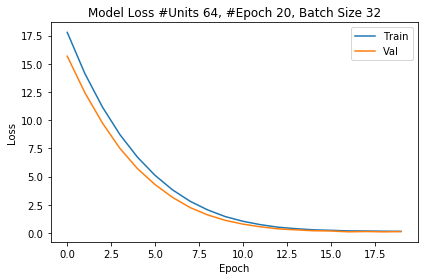

Accuracy: 95.60%
    Naive Mean Test Results
    Client dataset_00
Test Accuracy:  0.956
Test F1 Score:  0.956
Test Precision:  0.956
Test Recall:  0.956


0.956

In [17]:
test(client1)